# Zastosowanie wielomianów ortogonalnych w medycynie obliczeniowej


 Użycie wielomianów ortogonalnych do analizy EKG 

Instalacja wymaganych pakietów

In [1]:
using Pkg

In [2]:
# Pkg.add("Polynomials")
#Pkg.add("SpecialPolynomials")
# Pkg.add("Plots")
#Pkg.add("CSV")
#Pkg.add("DataFrames")

In [3]:
using Polynomials
using SpecialPolynomials
using Plots
using LinearAlgebra
using CSV
using DataFrames

## Teoria

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch róznych wielomianów jest równa 0.

Jeżeli dodatkowo iloczyn skalarny wielomianu "przez siebie" jest równy 1, to nazywamy je **wielomianami ortonormalnymi**

Iloczyn skalarny wielomianów można zdefiniować jako:

$<P_m,P_n>=\int_a^b P_n(x)P_m(x)W(x)dx = 0$

Funkcja *W* jest nazywana *funkcją wagową*.

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:

$H_0(x) = 1$

$H_1(x) = 2x$

$H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}$

Wykres przykładowego wielomianu (tutaj 3 stopnia)

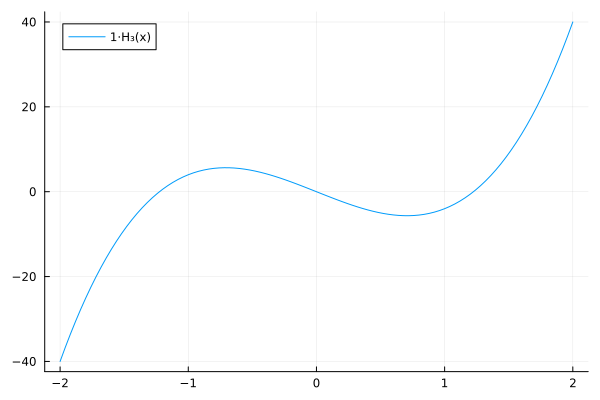

In [4]:
h3 = Hermite([0, 0, 0, 1])
plot(h3, -2, 2)

Żeby nie podawać wektora ze współczynnikami kolejnych stopni, można zrobić inaczej

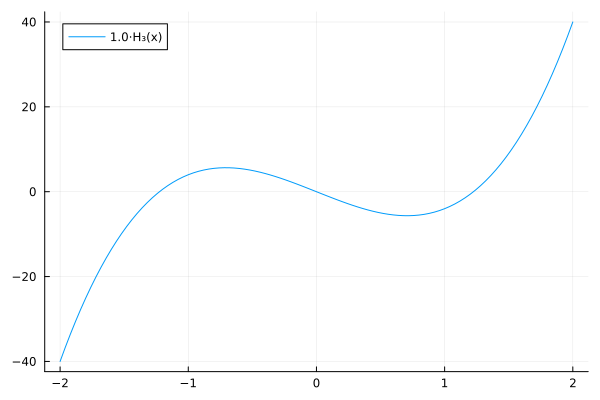

In [5]:
h4 = basis(Hermite, 3)
plot(h4, -2, 2)

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

In [6]:
# Definicja węzłów
xx = -5:0.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5;

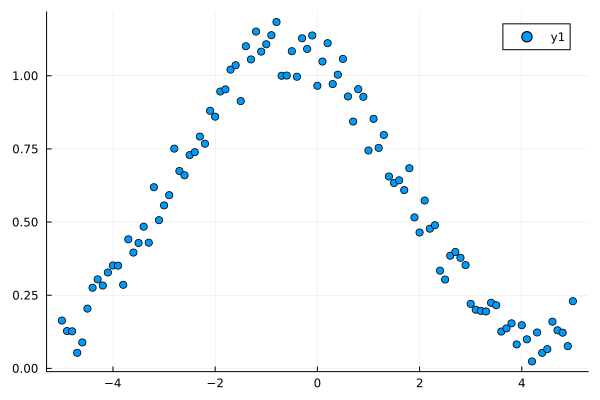

In [7]:
scatter(xx, yy, markershape=:circle)

Obliczony wektor wartości normalizujemy do 1, żeby łatwiej policzyć współczynniki aproksymacji (niżej objaśnienie dlaczego łatwiej). 

In [8]:
#przykład prostego wektora, który znormalizujemy
vec=[2,2,2,2]

4-element Vector{Int64}:
 2
 2
 2
 2

In [9]:
# iloczyn skalarny = długość^2
dot(vec,vec)

16

In [10]:
# normalizacja - długość wektora =1
normalize(vec)

4-element Vector{Float64}:
 0.5
 0.5
 0.5
 0.5

In [11]:
# sprawdzamy długość^2
dot(normalize(vec), normalize(vec))

1.0

* 0bliczamy funkcję bazową uwzględniającą czynnik wagowy.
$<P_m,P_n>=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy


In [12]:
# obliczamy funkcję bazową
# argument 'norm'  na potrzeby wykresów
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    # normalize to have norm 1
    if norm
        return normalize(app)
    end
    return app
end

base_fun (generic function with 2 methods)

In [13]:
y_2_unnorm = base_fun(2, xx, false);
y_2_norm = base_fun(2, xx);

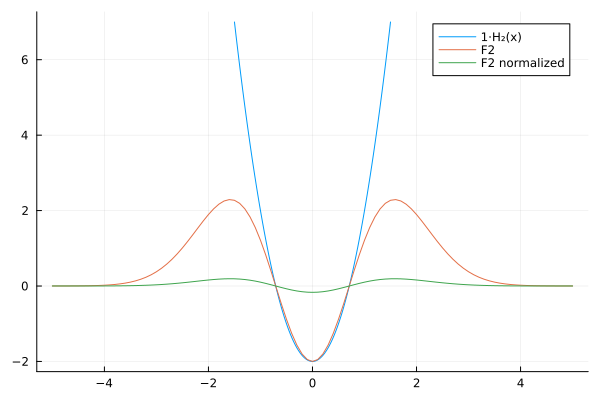

In [14]:
plot(Hermite([0, 0, 1]), -1.5, 1.5)
plot!(xx, y_2_unnorm, label="F2")
plot!(xx, y_2_norm, label="F2 normalized")

Obliczamy wektory wartosci dla punktów w xx dla kilku kolejnych funkcji bazowych

In [15]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);

Sprawdźmy czy baza jest ortonormalna (uwaga: zamiast liczyć całkę, sprawdzamy po prostu iloczyn skalarny wektorów wartości. Jeśli wartości są wystarczająco "gęsto" jest do dobre przybliżenie).

In [16]:
dot_base = Array{Float64, 2}(undef, 4, 4); 

for (i, f_i) in enumerate([f0, f1, f2, f3]) 
    for (j, f_j) in enumerate([f0, f1, f2, f3])
        dot_base[i,j] = dot(f_i, f_j)
    end
end

In [17]:
dot_base

4×4 Matrix{Float64}:
  1.0           1.17804e-17  -3.25356e-11   1.85612e-18
  1.17804e-17   1.0           8.46587e-18  -9.61163e-10
 -3.25356e-11   8.46587e-18   1.0          -7.22228e-18
  1.85612e-18  -9.61163e-10  -7.22228e-18   1.0

OK, baza jest ortonormalna

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektor bazowy jest znormalizowany $|\vec{j}|=1$, co upraszcza obliczenia.

Analogia w 2D

$\text{rzut }\vec{a} \text{ w kierunku }  \vec{j} =|\vec{a}|\cdot cos(\angle(\vec{a},\vec{j}))=|\vec{a}|\cdot|\vec{j}|\cdot cos(\angle(\vec{a},\vec{j}))=dot(\vec{a},\vec{j})$

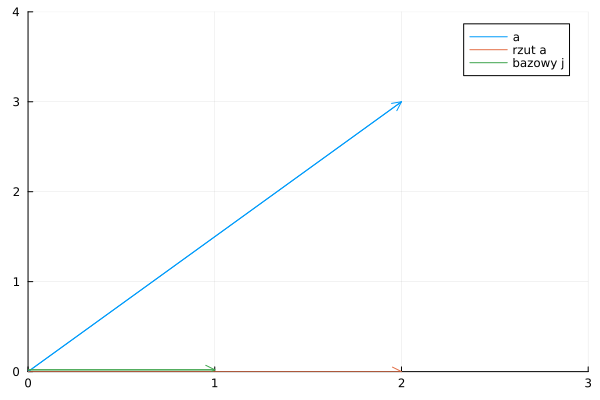

In [18]:
plot([0,2],[0,3],xrange=[0,3], yrange=[0,4],arrow=true, label="a")
plot!([0,2],[0,0],xrange=[0,3], yrange=[0,4],arrow=true, label="rzut a")
plot!([0,1],[0.02,0.02],xrange=[0,3], yrange=[0,4],arrow=true, label="bazowy j")

In [19]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c0, c1, c2, c3

(5.768139241205289, -0.8783981401203018, 2.733849890123423, -0.7205853069207417)

Liczymy wartości aproksymowane kolejnymi stopniami

In [20]:
y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;

In [21]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;

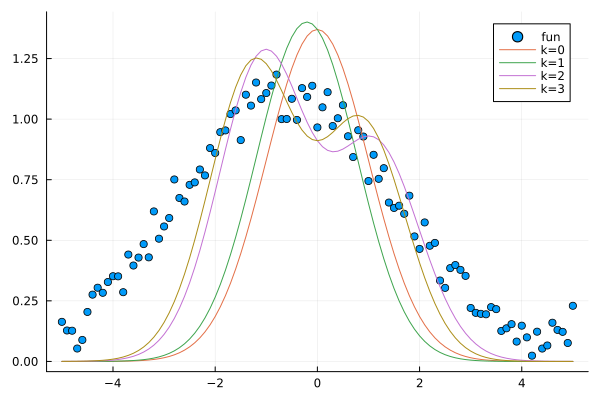

In [22]:
scatter(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")

Liczymy błędy aproksymacji kolejnymi stopniami

In [23]:
using Statistics

In [24]:
mse(y1, y2) = mean((y1-y2).^2)

mse (generic function with 1 method)

In [25]:
mse(yy, y_app_0)

0.13142861456961957

In [26]:
mse(yy, y_app_01)

0.12378917602935417

In [27]:
mse(yy, y_app_012)

0.04978981738822564

In [28]:
mse(yy, y_app_0123)

0.04464879574697004

### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [29]:
ekg_data = CSV.read("ecg_data.csv", DataFrame);

In [30]:
first(ekg_data, 5)

Row,time,signalN,signalV
,Float64,Float64,Float64
1,-0.1,0.0183886,-0.0990972
2,-0.0972222,0.0145191,-0.0920442
3,-0.0944444,0.012849,-0.0831644
4,-0.0916667,0.0124946,-0.0722728
5,-0.0888889,0.0124117,-0.0593656


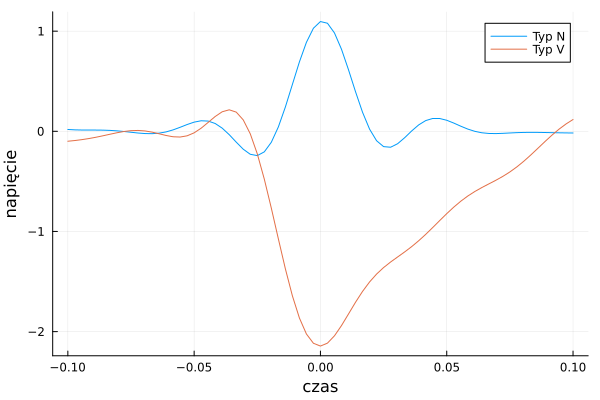

In [31]:
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

(5.725113911598116, -0.9157906158817669, 2.711325477169205, -0.8018390195854078)

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [32]:
# Definicja węzłów
xx_ekg = ekg_data.time*40
yy_ekgV = ekg_data.signalV;

## Zadania

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2) $H_m(x)$, $m \in \{0,1,...,5\}$

Podobnie  narysować 6 pierwszych funkcji bazowych z uwzględnieniem czynnika wagowego $H_m(x)\exp(-\frac{x^2}{2})$, $m \in \{0,1,...,5\}$

#### Zadanie 2 (1 pkt)

Pokazać, że same wielomiany nie są ortogonane, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

#### Zadanie 3  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

#### Zadanie 4  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?

In [ ]:
using Plots
using SpecialPolynomials

# Zakres x
x = -4:0.01:4

# Generowanie wielomianów Hermite’a H₀ do H₅
hermite_polys = [Hermite([zeros(n)..., 1]) for n in 0:5]
H_vals = [p.(x) for p in hermite_polys]  # Ewaluacja Hₙ(x)
weighted_H = [H .* exp.(-x.^2 ./ 2) for H in H_vals]  # Hₙ(x) * exp(-x² / 2)

# Wykres 1: Hermite H_m(x)
p1 = plot(layout = (2, 3), size=(900, 600), title="Wielomiany Hermite'a Hₘ(x)")
for m in 0:5
    plot!(p1[m+1], x, H_vals[m+1], label = "H_$m(x)", legend = :topright)
end

# Wykres 2: H_m(x) * exp(-x^2 / 2)
p2 = plot(layout = (2, 3), size=(900, 600), title="Bazowe funkcje Hermite’a: Hₘ(x)e^{-x²/2}")
for m in 0:5
    plot!(p2[m+1], x, weighted_H[m+1], label = "ψ_$m(x)", legend = :topright)
end

# Zapisz wykresy
savefig(p1, "hermite_polynomials1.png")
savefig(p2, "hermite_polynomials2.png")


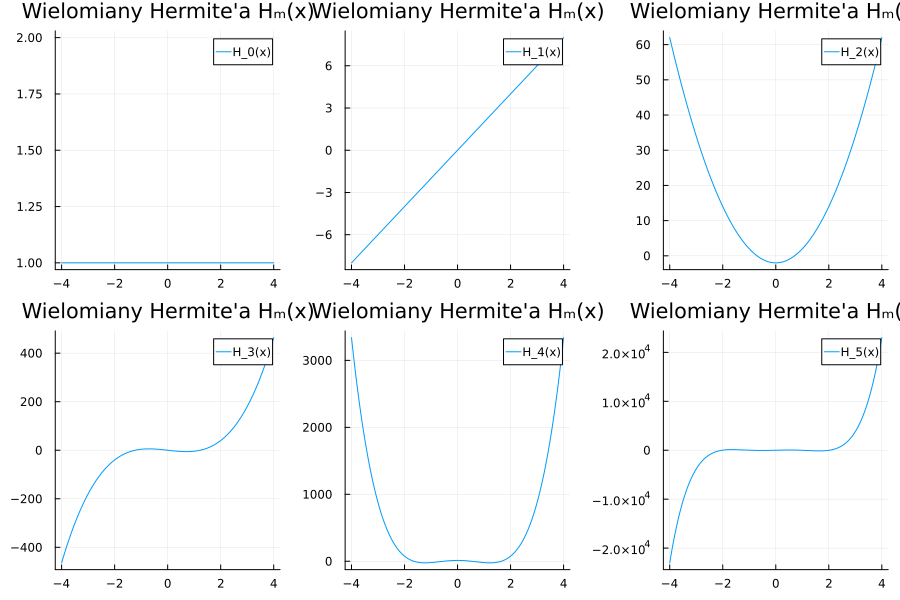

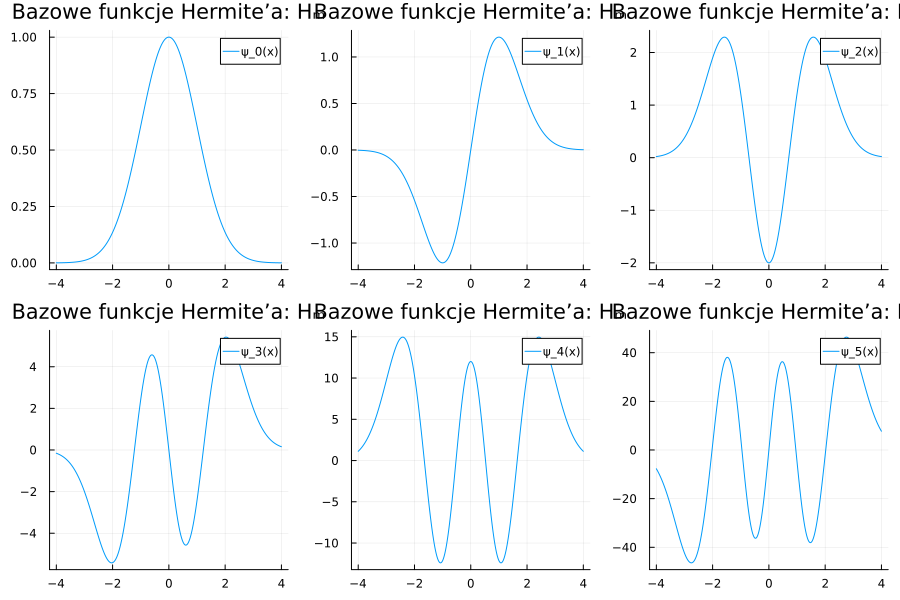

In [ ]:
using Plots
using SpecialPolynomials
using LinearAlgebra
using Statistics

# Ustawienia
x = -5:0.005:5
dx = step(x)
n = 6  # liczba funkcji: 0..5

# Tworzenie wielomianów Hermite’a Hₙ(x)
H_polys = [Hermite([zeros(m)..., 1]) for m in 0:n-1]
H_vals = [p.(x) for p in H_polys]

# Znormalizowane funkcje bazowe Hermite’a (ψₙ(x) = Hₙ(x) * exp(-x^2/2) / sqrt(2ⁿ n! √π))
function normalized_hermite(H_vals::Vector{Float64}, n::Int)
    norm_const = sqrt(2.0^n * factorial(n) * sqrt(π))
    return H_vals .* exp.(-x.^2 ./ 2) ./ norm_const
end

ψ_vals = [normalized_hermite(H_vals[i], i-1) for i in 1:n]

# Macierz iloczynów skalarnych (funkcji H_n(x) bez wagi)
inner_H = zeros(n, n)
for i in 1:n, j in 1:n
    inner_H[i, j] = sum(H_vals[i] .* H_vals[j]) * dx
end

# Macierz iloczynów skalarnych (ψ_n, z wagą e^{-x²/2}, znormalizowane)
inner_ψ = zeros(n, n)
for i in 1:n, j in 1:n
    inner_ψ[i, j] = sum(ψ_vals[i] .* ψ_vals[j]) * dx
end

# Wyniki
println("Iloczyny skalarne wielomianów Hermite’a (bez wagi):")
display(round.(inner_H, digits=2))

println("\nIloczyny skalarne funkcji Hermite’a ψₙ(x) (z wagą, ortonormalne):")
display(round.(inner_ψ, digits=3))


Iloczyny skalarne wielomianów Hermite’a (bez wagi):
6×6 Matrix{Float64}:
    10.01     -0.0          313.82           0.0        16164.1         0.0      
    -0.0     333.83           0.0        18047.0           -0.0         1.05261e6
   313.82      0.0        18754.7           -0.0            1.16465e6  -0.0      
     0.0   18047.0           -0.0            1.20499e6      0.0         7.78276e7
 16164.1      -0.0            1.16465e6      0.0            8.04796e7   0.0      
     0.0       1.05261e6     -0.0            7.78276e7      0.0         5.37506e9

Iloczyny skalarne funkcji Hermite’a ψₙ(x) (z wagą, ortonormalne):
6×6 Matrix{Float64}:
  1.0   0.0  -0.0  -0.0  -0.0   0.0
  0.0   1.0  -0.0  -0.0   0.0  -0.0
 -0.0  -0.0   1.0   0.0  -0.0   0.0
 -0.0  -0.0   0.0   1.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0   1.0  -0.0
  0.0  -0.0   0.0  -0.0  -0.0   1.0

In [ ]:
using CSV
using DataFrames
using Plots
using Polynomials

# Wczytanie danych z pliku CSV
data = CSV.File("ecg_data.csv")
df = DataFrame(data)

# Wydzielenie sygnałów N i V
time = df.time
signalN = df.signalN
signalV = df.signalV

# Stopnie wielomianów do aproksymacji
degrees = [3, 4, 5, 6, 7, 8]
colors = [:red, :orange, :purple, :brown, :pink, :cyan]

# Aproksymacja dla sygnału N z różnymi stopniami wielomianu
p_N = plot(time, signalN, label="Sygnał N", xlabel="Czas", ylabel="Amplituda", color=:blue, 
           title="Aproksymacja sygnału N", linewidth=2, legend=:topleft)

for (i, degree) in enumerate(degrees)
    poly = fit(Polynomial, time, signalN, degree)
    plot!(p_N, time, [poly(t) for t in time], label="Stopień $degree", 
          linestyle=:dash, color=colors[i], linewidth=1.5)
end

# Aproksymacja dla sygnału V z różnymi stopniami wielomianu
p_V = plot(time, signalV, label="Sygnał V", xlabel="Czas", ylabel="Amplituda", color=:green,
           title="Aproksymacja sygnału V", linewidth=2, legend=:topleft)

for (i, degree) in enumerate(degrees)
    poly = fit(Polynomial, time, signalV, degree)
    plot!(p_V, time, [poly(t) for t in time], label="Stopień $degree", 
          linestyle=:dash, color=colors[i], linewidth=1.5)
end

# Zapisanie wykresów do plików
savefig(p_N, "aproksymacja_N.png")
savefig(p_V, "aproksymacja_V.png")

# Wyświetlenie wykresów
display(p_N)
display(p_V)

# Zapisanie obu wykresów na jednym obrazku (opcjonalnie)
p_combined = plot(p_N, p_V, layout=(2,1), size=(800, 1000))
savefig(p_combined, "aproksymacje_N_V.png")

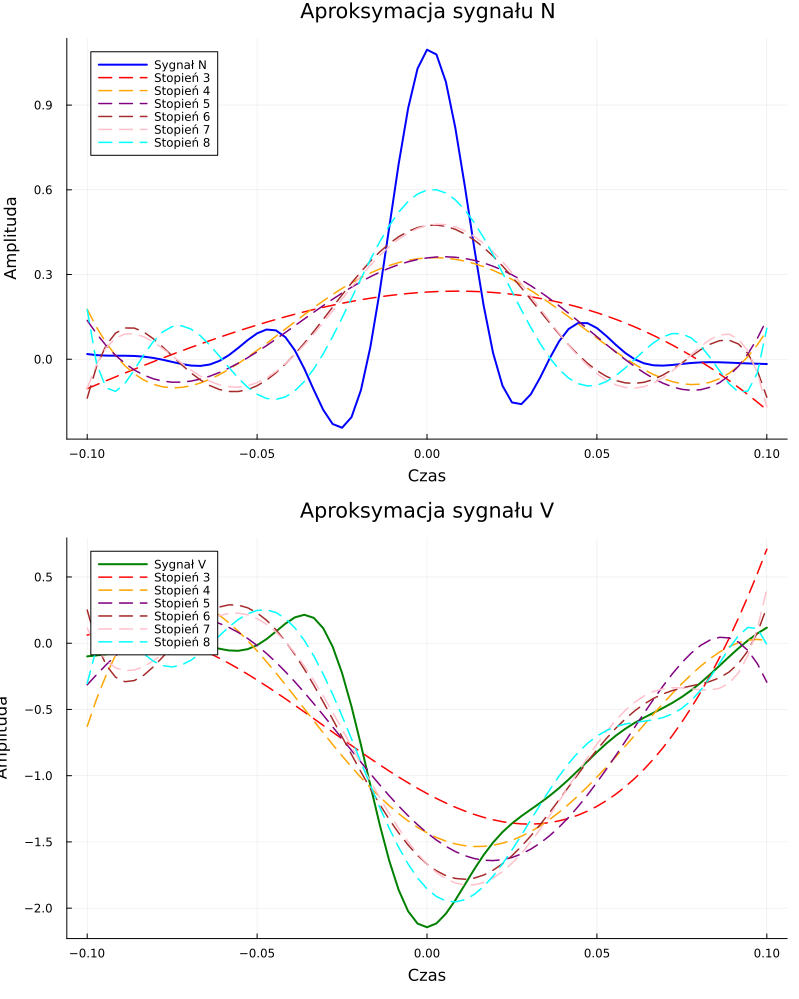

In [ ]:
using CSV
using DataFrames
using Plots
using Polynomials

# Wczytanie danych z pliku CSV
data = CSV.File("ecg_data.csv")
df = DataFrame(data)

# Wydzielenie sygnałów N i V
time = df.time
signalN = df.signalN
signalV = df.signalV

# Funkcja do obliczania błędu aproksymacji
function approximation_error(poly, time, signal)
    predicted = [poly(t) for t in time]
    error = sum((predicted .- signal).^2) / length(time)
    return error
end

# Przechowywanie błędów dla różnych stopni
errors_N = Float64[]
errors_V = Float64[]

# Aproksymacja i obliczanie błędów dla stopni od 0 do 10
for degree in 0:12
    poly_N = fit(Polynomial, time, signalN, degree)
    poly_V = fit(Polynomial, time, signalV, degree)
    
    # Obliczanie błędu aproksymacji dla sygnału N i V
    push!(errors_N, approximation_error(poly_N, time, signalN))
    push!(errors_V, approximation_error(poly_V, time, signalV))
end

# Tworzenie wykresu błędu aproksymacji
plot(0:12, errors_N, label="Błąd aproksymacji N", xlabel="Stopień wielomianu", ylabel="Błąd", color=:blue)
plot!(0:12, errors_V, label="Błąd aproksymacji V", linestyle=:dash, color=:red)

# Wyświetlenie wykresu
display(plot)

# Zapisanie wykresu do pliku
savefig("approximation_error_plot.png")

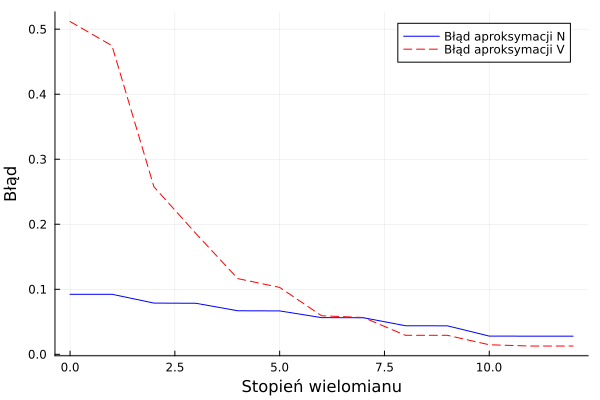